<a href="https://colab.research.google.com/github/raul-rufato/smt/blob/newsmt/tutorial/SMT_MixedInteger_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="jumbotron text-left"><b>
    
This tutorial describes how to perform a mixed optimization using the SMT toolbox. The idea is to use a Bayesian Optimization (EGO method) to solve an unconstrained optimization problem with mixed variables.
<div>
    
    October 2020
  
    Paul Saves and Nathalie BARTOLI ONERA/DTIS/M2CI)

<p class="alert alert-success" style="padding:1em">
To use SMT models, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper is available 
here https://www.sciencedirect.com/science/article/pii/S0965997818309360?via%3Dihub 

or as a preprint: http://mdolab.engin.umich.edu/content/python-surrogate-modeling-framework-derivatives

For mixed integer with continuous relaxation, the reference paper is available here https://www.sciencedirect.com/science/article/pii/S0925231219315619

### Mixed Integer EGO

For mixed integer EGO, the model is the continuous one. The discrete variables being relaxed continuously

In [1]:
!pip install smt

     |████████████████████████████████| 252 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51 kB 409 kB/s 
     |████████████████████████████████| 3.1 MB 44.5 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 121 kB 42.0 MB/s 
     |████████████████████████████████| 100 kB 9.5 MB/s 
     |████████████████████████████████| 90 kB 9.0 MB/s 
  Created wheel for smt: filename=smt-1.2.0-cp37-cp37m-linux_x86_64.whl size=524623 sha256=ba0417d000f991292559f3d0bd1b4c9116146317b9ea72c664a9ac304f86100e
  Stored in directory: /root/.cache/pip/wheels/3d/69/1e/ae0014b43757c2db9bdd61fdae3a4f532f9d64c451a1bc678e
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256=fba0a79afed6d93b4d6cc4f57f923207aaf3efdcb88bc0bf7e954a12f238fea6
  Stored in directory: /root/.cache/pip/wheels/49/91/2d/d08e808

In [2]:
%matplotlib inline  

from math import exp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import minimize
import scipy
import six
from smt.applications import EGO
from smt.surrogate_models import KRG
from smt.sampling_methods import FullFactorial
from smt.sampling_methods import LHS
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import matplotlib.font_manager
from smt.applications.mixed_integer import MixedIntegerSurrogateModel

import warnings
warnings.filterwarnings("ignore")

from smt.applications.mixed_integer import (
    FLOAT,
    ORD,
    ENUM,
    MixedIntegerSamplingMethod,
    cast_to_mixed_integer, unfold_with_enum_mask
)


Definition of the plot function 

In [ ]:
def PlotEgo(criterion, xdoe, bounds,npt,n_iter=12,xtypes=None, sm=KRG(print_global=False)) :
    ego = EGO(n_iter=n_iter, criterion=criterion, xdoe=xdoe,xtypes=xtypes, xlimits=bounds,n_start=20,n_max_optim=35,enable_tunneling=False, surrogate=sm)
    x_opt, y_opt, ind_best, x_data, y_data = ego.optimize(fun=f)
    print("Minimum in x={:.0f} with f(x)={:.10f}".format(int(x_opt), float(y_opt)))

    x_plot = np.atleast_2d(np.linspace(bounds[0][0], bounds[0][1], 9*(npt-1)+1)).T
    fig = plt.figure(figsize=[15, 15])
    for i in range(n_iter):
        k = n_doe + i
        x_data_k = x_data[0:k]
        y_data_k = y_data[0:k]
        
            #if check list, not already evaluated
        y_data[k]=f(x_data[k][:, np.newaxis])
        ego.gpr.set_training_values(x_data_k, y_data_k)
        ego.gpr.train()
        y_gp_plot = ego.gpr.predict_values(x_plot)
        y_gp_plot_var = ego.gpr.predict_variances(x_plot)
        y_ei_plot = ego.EI(x_plot,False)
        ax = fig.add_subplot((n_iter + 1) // 2, 2, i + 1)
        ax1 = ax.twinx()
        ei, = ax1.plot(x_plot, y_ei_plot, color="red")

        true_fun = ax.scatter(Xsol, Ysol,color='k',marker='d')
        data, = ax.plot(
            x_data_k, y_data_k, linestyle="", marker="o", color="orange"
        )
        if i < n_iter - 1:
            opt, = ax.plot(
                x_data[k], y_data[k], linestyle="", marker="*", color="r"
            )
            print(x_data[k], y_data[k])
        gp, = ax.plot(x_plot, y_gp_plot, linestyle="--", color="g")        
        sig_plus = y_gp_plot + 3 * np.sqrt(y_gp_plot_var)
        sig_moins = y_gp_plot - 3 * np.sqrt(y_gp_plot_var)
        un_gp = ax.fill_between(
            x_plot.T[0], sig_plus.T[0], sig_moins.T[0], alpha=0.3, color="g"
        )
        lines = [true_fun, data, gp, un_gp, opt, ei]
        fig.suptitle("EGO optimization of a set of points")
        fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.8)
        ax.set_title("iteration {}".format(i + 1))
        fig.legend(
            lines,
            [
                "set of points",
                "Given data points",
                "Kriging prediction",
                "Kriging 99% confidence interval",
                "Next point to evaluate",
                "Expected improvment function",
            ],
        )
    plt.show()

## Local minimum trap: 1D function 
 The 1D function to optimize is described by: 
- 1 discrete variable $\in [0, 25]$

In [ ]:
#definition of the 1D function
def f(X) :
    x= X[:, 0]
    if (np.abs(np.linalg.norm(np.floor(x))-np.linalg.norm(x))< 0.000001):
        y = (x - 3.5) * np.sin((x - 3.5) / (np.pi))
    else :
        print("error")
    return y

Min of the DOE:  -15.121611536143384


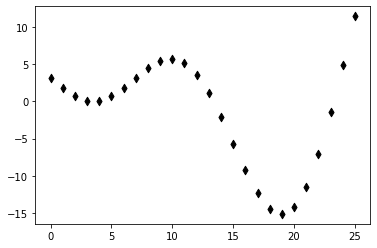

In [ ]:
#to plot the function
bounds = np.array([[0, 25]])
npt=26

Xsol = np.linspace(bounds[0][0],bounds[0][1], npt)
Xs= Xsol[:, np.newaxis]
Ysol = f(Xs)
print("Min of the DOE: ",np.min(Ysol)) 
plt.scatter(Xs,Ysol,marker='d',color='k')
plt.show()

Minimum in x=19 with f(x)=-15.1216115361
[1.] [1.78601478]
[2.] [0.68929352]
[3.] [0.07924194]
[25.] [11.42919546]
[17.] [-12.35295142]
[18.] [-14.43198471]
[20.] [-14.15453288]
[19.] [-15.12161154]
[19.] [-15.12161154]


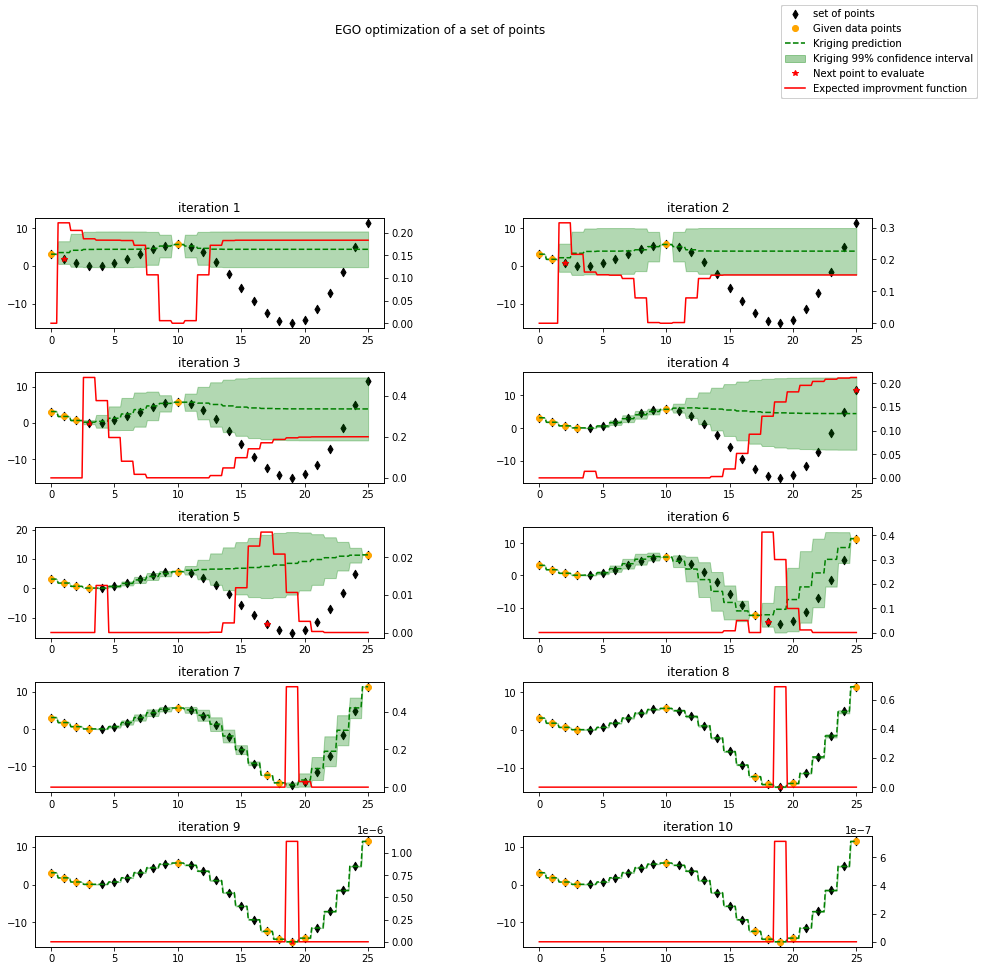

In [ ]:
#to run the optimization process
n_iter = 10
xdoe = np.atleast_2d([0,10]).T
n_doe = xdoe.size
xtypes=[ORD]
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
PlotEgo(criterion,xdoe,bounds,npt,n_iter,xtypes=xtypes)


On this 1D test case, 4 iterations are required to find the global minimum, evaluated at iteration 5.

 ## 1D function with noisy values
 The 1D function to optimize is described by: 
- 1 discrete variable $\in [0, 60]$

In [ ]:
def f(X) :
    x= X[:, 0]
    y = -np.square(x-25)/220+0.25*(np.sin((x - 3.5) * np.sin((x - 3.5) / (np.pi)))+np.cos(x**2))
    np.random.seed(10)
    y2 = y+3*np.random.uniform(size=y.shape)
    return -y2

min of the DOE:  -2.6466034697899508


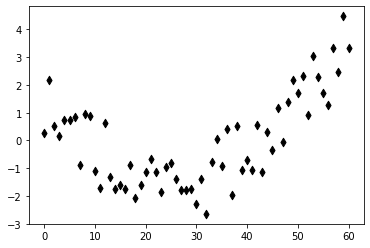

In [ ]:
#to plot the function
xlimits = np.array([[0, 60]])
npt=61


Xsol = np.linspace(xlimits[0][0],xlimits[0][1], npt)
Xs= Xsol[:, np.newaxis]

Ysol = f(Xs)



print("min of the DOE: ", np.min(Ysol))
plt.scatter(Xs,Ysol,marker='d',color='k')
plt.show()

Minimum in x=21 with f(x)=-2.5624667634
[22.] [-2.33445099]
[60.] [2.80551835]
[17.] [-2.32591559]
[20.] [-1.81903918]
[24.] [-1.94863943]
[21.] [-2.56246676]
[17.] [-2.32591559]
[19.] [-1.77194943]
[23.] [-2.13442069]


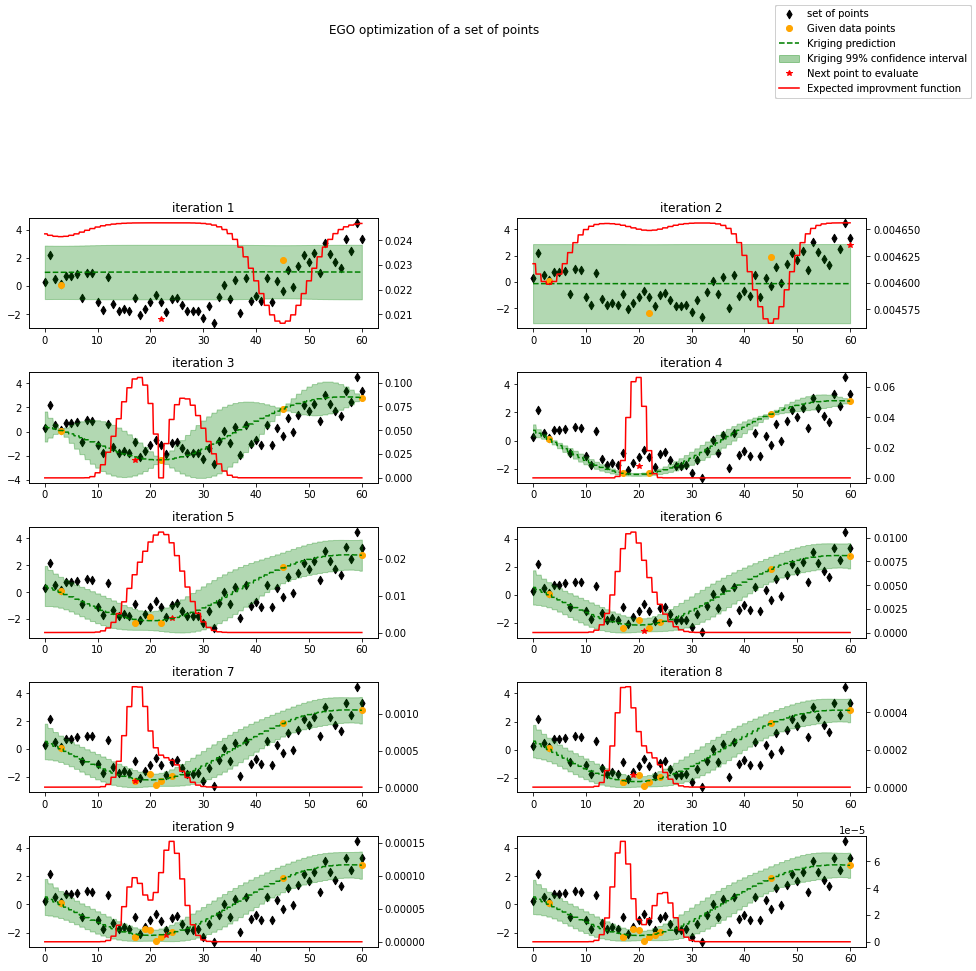

In [ ]:
#to run the optimization process
n_iter = 10
n_doe=2
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xdoe = sampling(n_doe)
xtypes=[ORD]
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
sm=KRG(print_global=False,eval_noise= True)
PlotEgo(criterion,xdoe,xlimits,npt,n_iter,xtypes,sm=sm)


- On this noisy case, it toook 7 iterations to understand the shape of the curve but then, it took time to explore the random noise aroudn the minimum.

## 2D mixed branin function
The 2D function to optimize is described by: 
- 1 discrete variable $\in [-5, 10]$
- 1 continuous variable $\in [0., 15.]$

In [ ]:
#definition of the 2D function
#the first variable is a integer one and the second one is a continuous one
import math
def f(X) :
    x1 = X[:,0]
    x2 = X[:,1]
    PI = math.pi #3.14159265358979323846
    a = 1
    b = 5.1/(4*np.power(PI,2))
    c = 5/PI
    r = 6   
    s = 10
    t = 1/(8*PI)
    y=  a*(x2 - b*x1**2 + c*x1 -r)**2 + s*(1-t)*np.cos(x1) + s
    return y

In [ ]:
#to define and compute the doe 
xtypes = [ORD, FLOAT]
xlimits = np.array([[-5.0, 10.0],[0.0,15.0]])
n_doe=20
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xt = sampling(n_doe)
yt = f(xt)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0728171
   
   Prediction time/pt. (sec) :  0.0000073
   


Text(0.5, 1.0, 'surrogate mean response')

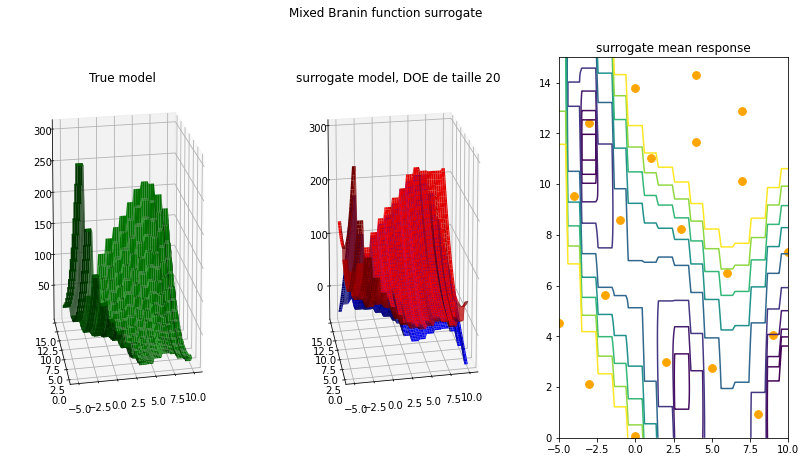

In [ ]:
#to build the mixed surrogate model
sm = MixedIntegerSurrogateModel(xtypes=xtypes, xlimits=xlimits, surrogate=KRG())
sm.set_training_values(xt, yt)
sm.train()

num = 100
x = np.linspace(-5.0,10., 100)
y = np.linspace(0,15., 100)
xv, yv = np.meshgrid(x, y)
x_plot= np.array([np.ravel(xv), np.ravel(yv)]).T
y_plot = f(np.floor(x_plot))

fig = plt.figure(figsize=[14, 7])

y_gp_plot = sm.predict_values(x_plot)
y_gp_plot_sd = np.sqrt(sm.predict_variances(x_plot))
l=y_gp_plot-3*y_gp_plot_sd
h=y_gp_plot+3*y_gp_plot_sd
ax =  fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d') 
ax2 = fig.add_subplot(1, 3,3)  

ii=-100
ax.view_init(elev=15., azim=ii)
ax1.view_init(elev=15., azim=ii)

true_fun = ax.plot_surface(xv, yv, y_plot.reshape((100, 100)), label ='true_function',color='g')
data3 = ax2.scatter(xt.T[0],xt.T[1],s=60,marker="o",color="orange")
gp1 = ax1.plot_surface(xv, yv, l.reshape((100, 100)), color="b")
gp2 = ax1.plot_surface(xv, yv, h.reshape((100, 100)), color="r")  
gp3 = ax2.contour(xv, yv, y_gp_plot.reshape((100, 100)), color="k", levels=[0,1,2,5,10,20,30,40,50,60])
fig.suptitle("Mixed Branin function surrogate")
ax.set_title("True model")
ax1.set_title("surrogate model, DOE de taille {}".format(n_doe))
ax2.set_title("surrogate mean response")

- On the left, we have the real model in green.  
- In the middle we have the mean surrogate $+3\times \mbox{ standard deviation}$ (red) and the mean surrogate $-3\times \mbox{ standard deviation}$  (blue) in order to represent an approximation of the $99\%$ confidence interval.

- On the right, the contour plot of the mean surrogate are given where yellow points are the values at the evaluated points (DOE).

## 4D mixed test case

The 4D function to optimize is described by: 
- 1 continuous variable $\in [-5, 5]$
- 1 categorical variable with 3 labels $["blue", "red", "green"]$
- 1 categorical variable with 2 labels $ ["large", "small"]$ 
- 1 discrete variable $\in [0, 2]$

Initial DOE: 
 xdoe =  [[ 1.76335604  2.          1.          1.        ]
 [-2.84531634  1.          0.          0.        ]
 [ 1.17044703  2.          0.          2.        ]] 
 ydoe =  [ 6.02556471 -5.69063269  5.51134108]


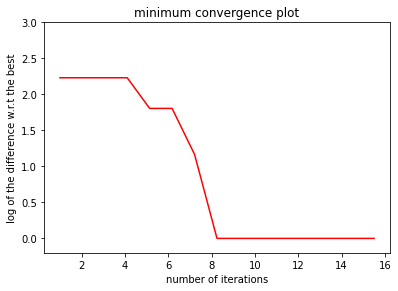

In [ ]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 0]
    #  enum 1
    c1 = X[:, 1]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 2]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 3]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y
#to run the optimization process
n_iter = 15
xtypes = [FLOAT, (ENUM, 3), (ENUM, 2), ORD]
xlimits = np.array([[-5, 5], ["blue", "red", "green"], ["large", "small"], [0, 2]])
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"
sm = KRG(print_global=False)

n_doe = 3
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    xtypes=xtypes,
    xlimits=xlimits,
    surrogate=sm,
    qEI=qEI,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()



In [ ]:
print(" 4D EGO Optimization: Minimum in x=",cast_to_mixed_integer(xtypes, xlimits, x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= [-5.0, 'green', 'large', 1] with y value = [-14.]


## Manipulate the DOE

In [ ]:

#to give the initial doe in the initial space
print('Initial DOE in the initial space: ')
for i in range(n_doe):
    print("Doe point  i={} ={}".format((i), (cast_to_mixed_integer(xtypes, xlimits, xdoe[i]))),'\n')
    
#to give the initial doe in the relaxed space
print('Initial DOE in the unfold space (or relaxed space): ')
for i in range(n_doe):
    print("Doe point  i={} ={}".format((i), (unfold_with_enum_mask(xtypes,  xdoe[i]))),'\n')
    
#to print the used DOE
print('Initial DOE in the fold space: ')
for i in range(n_doe):
    print("Doe point  i={} ={}".format((i), xdoe[i]),'\n')

        

Initial DOE in the initial space: 
Doe point  i=0 =[1.7633560381691238, 'green', 'small', 1] 

Doe point  i=1 =[-2.8453163429490678, 'red', 'large', 0] 

Doe point  i=2 =[1.1704470263005584, 'green', 'large', 2] 

Initial DOE in the unfold space (or relaxed space): 
Doe point  i=0 =[[1.76335604 0.         0.         1.         0.         1.
  1.        ]] 

Doe point  i=1 =[[-2.84531634  0.          1.          0.          1.          0.
   0.        ]] 

Doe point  i=2 =[[1.17044703 0.         0.         1.         1.         0.
  2.        ]] 

Initial DOE in the fold space: 
Doe point  i=0 =[1.76335604 2.         1.         1.        ] 

Doe point  i=1 =[-2.84531634  1.          0.          0.        ] 

Doe point  i=2 =[1.17044703 2.         0.         2.        ] 



# Gower mixed based surrogate model 2D function 

The function is described by: 
- 1 continuous variable $\in [0, 4]$
- 1 categorical variable with 2 labels $["Blue", "Red"]$

For mixed integer with Gower distance, the reference thesis is available here https://eldorado.tu-dortmund.de/bitstream/2003/35773/1/Dissertation_%20Halstrup.pdf

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0119917
   
   Prediction time/pt. (sec) :  0.0001199
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 100
   
   Predicting ...
   Predicting - done. Time (sec):  0.0118473
   
   Prediction time/pt. (sec) :  0.0001185
   


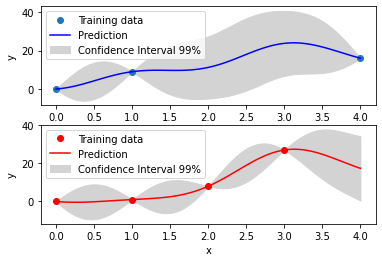

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from smt.surrogate_models import KRG
from smt.applications.mixed_integer import MixedIntegerSurrogateModel, ENUM,ORD,FLOAT,GOWER, HOMO_GAUSSIAN

xt1 = np.array([[0,0.0],
               [0,1.0],
               [0,4.0]])
xt2 = np.array([[1,0.0],
               [1,1.0],
               [1,2.0],
               [1,3.0]])
xt = np.concatenate((xt1, xt2), axis=0)
xt[:,1] = xt[:,1].astype(np.float) 
yt1 = np.array([0.0, 9.0, 16.0])
yt2 = np.array([ 0.0, 1.0,8.0,27.0])
yt = np.concatenate((yt1, yt2), axis=0)
xlimits =  [["Blue","Red"],[0.0,4.0]]
xtypes=[(ENUM, 2),FLOAT]
# Surrogate
sm = MixedIntegerSurrogateModel(categorical_kernel = HOMO_GAUSSIAN, xtypes=xtypes, xlimits=xlimits, surrogate=KRG(theta0=[1e-2]))
sm.set_training_values(xt, yt)
sm.train()

# DOE for validation
n = 100
x_cat1 = []
x_cat2 = []
for i in range(n):
    x_cat1.append(0)
    x_cat2.append(1)

x_cont = np.linspace(0.0, 4.0, n)
x1 = np.concatenate((np.asarray(x_cat1).reshape(-1,1), x_cont.reshape(-1,1)), axis=1)
x2 = np.concatenate((np.asarray(x_cat2).reshape(-1,1), x_cont.reshape(-1,1)), axis=1) 

y1 = sm.predict_values(x1)
y2 = sm.predict_values(x2)

# estimated variance
s2_1 = sm.predict_variances(x1)
s2_2 = sm.predict_variances(x2)

fig, axs = plt.subplots(2)
axs[0].plot(xt1[:,1].astype(np.float), yt1,'o',linestyle="None")
axs[0].plot(x_cont, y1,color ='Blue')
axs[0].fill_between(
    np.ravel(x_cont),
    np.ravel(y1 - 3 * np.sqrt(s2_1)),
    np.ravel(y1 + 3 * np.sqrt(s2_1)),
    color="lightgrey",
)
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].legend(
    ["Training data", "Prediction", "Confidence Interval 99%"],
    loc="upper left",
)
axs[1].plot(xt2[:,1].astype(np.float), yt2, marker='o', color='r',linestyle="None")
axs[1].plot(x_cont, y2,color ='Red')
axs[1].fill_between(
    np.ravel(x_cont),
    np.ravel(y2 - 3 * np.sqrt(s2_2)),
    np.ravel(y2 + 3 * np.sqrt(s2_2)),
    color="lightgrey",
)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].legend(
    ["Training data", "Prediction", "Confidence Interval 99%"],
    loc="upper left",
)

plt.show()  



# Gower mixed based surrogate model 4D function

The database is available at https://www.sciencedirect.com/science/article/abs/pii/S1359835X11000224

The aim is to build a surrogate model for mixed variables in a hybrid composite problem. The trained surrogate model is able to predict the composites characteristics. 
This is a tutorial for the following paper: A mixed-categorical data-driven approach for prediction and
optimization of hybrid discontinuous composites performance. 

The function inputs are:



> 4 continuous variables  **[lf Vc SmAvg G GiicmAvg]**


> 2 categorical variables **[Carbon fibres Glass Fibres]** with 16 labels.


The possible outputs are **[Initial_stiffness	Ultimate_strain	Pseudo_ductile_strain	Ultimate_strength	Yield_strength]**

In this example, only the most influent continuous inputs are being used (**lf** and **Vc**), and the predicted variable is the **Initial Stiffness**

**lf:** length of the fibre. 

**Vc:** Percentage of carbon fibre in the mixture. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG
from smt.applications.mixed_integer import MixedIntegerSurrogateModel, ENUM,ORD,FLOAT,GOWER, HOMO_GAUSSIAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler
plt.rcParams.update({'legend.labelspacing':1.0})

In [19]:
try :
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # 1. Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    json_import = drive.CreateFile({'id':'1fcB39mktJ2npTNqrF8dgZa7PWh3wU55X'})
    json_import.GetContentFile('VTF_properties.json')
    df = pd.read_csv(open('VTF_properties.json'))
except :
    df = pd.read_csv(open('VTF_properties.csv'))

In [20]:
df = df.dropna()
df.head()

,Carbon_fibre,Glass_fibre,lf,Vc,SmAvg,G,GiicmAvg,Initial_stiffness,Ultimate_strain,Pseudo_ductile_strain,Ultimate_strength,Yield_strength
0,XN-90,GF,10533.482040,0.966017,82.354229,1056.370868,0.734474,456482.1982,0.24,0.050521,864.937397,864.937397
1,XN-90,XN-05,7808.946657,0.996472,60.848804,1741.249859,0.849103,466897.1657,0.24,0.040624,930.878853,930.878853
2,XN-90,GF,9323.678328,0.242948,53.269380,1523.664676,0.671576,169973.9748,0.18,0.033303,249.346203,249.346203
3,P120J,GF,5788.757208,0.453632,79.635912,1662.767083,0.776173,240985.5142,0.26,0.069889,458.139055,458.139055
4,XN-90,XN-05,11435.547280,0.837472,61.736593,1340.566744,0.658034,389829.4153,0.22,0.042216,693.053223,693.053223


In [ ]:
data = df.sample(n=1000,random_state = 10)
data.Carbon_fibre = pd.Categorical(data.Carbon_fibre)
data['Carbon_fibre'] = data.Carbon_fibre.cat.codes  
data.Glass_fibre = pd.Categorical(data.Glass_fibre)
data['Glass_fibre'] = data.Glass_fibre.cat.codes  
Xd = data.drop(['SmAvg','G','GiicmAvg','Initial_stiffness','Ultimate_strain','Pseudo_ductile_strain','Ultimate_strength',
             'Yield_strength'],axis = 1)

yd = data.Initial_stiffness

X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size = 0.25, random_state = 42)
X = np.asarray(X_train)
y = np.asarray(y_train).astype(float)
xtypes=[(ENUM, 16),(ENUM, 15),FLOAT,FLOAT]
xlimits =  [['XN-90', 'P120J', 'T1000GB', 'C124', 'T800H', 'M60JB', 'C320',
       'M40B', 'P75S', 'K13D', 'T300', 'XN-05', 'FliteStrand_S_ZT',
       'HTA5131', 'GF', 'C100'],['GF', 'XN-05', 'FliteStrand_S_ZT', 'C124', 'T300', 'T800H', 'C320',
       'P75S', 'C100', 'XN-90', 'HTA5131', 'T1000GB', 'P120J', 'M40B',
       'M60JB'],[501.5425023,11999.96175],[2.849e-05,1.0]]


In [ ]:
sm = MixedIntegerSurrogateModel(categorical_kernel = GOWER, xtypes=xtypes, xlimits=xlimits, surrogate=KRG(theta0=[1e-2]))
sm.set_training_values(X, y)
sm.train()

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 250
   
   Predicting ...
   Predicting - done. Time (sec):  0.0330420
   
   Prediction time/pt. (sec) :  0.0001322
   
r2_score =  0.9858956012965572


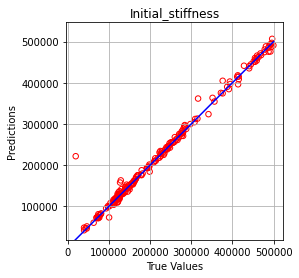

In [ ]:
y_pred2 =sm.predict_values(np.asarray(X_test))
y_pred2[y_pred2<0]=0

print("r2_score = ", r2_score(y_test, y_pred2))

plt.scatter(y_test, y_pred2, s=30, facecolors='none', edgecolors='r')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Initial_stiffness')
plt.axis('equal')
plt.axis('square')
plt.grid()
_ = plt.plot([-500000, 500000], [-500000, 500000],'b')

## Gower mixed based optimization 4D function 

Initial DOE: 
 xdoe =  [[ 0.          1.          1.         -4.03078046]
 [ 1.          0.          2.          0.40941497]] 
 ydoe =  [-2.82924143  2.81882994]


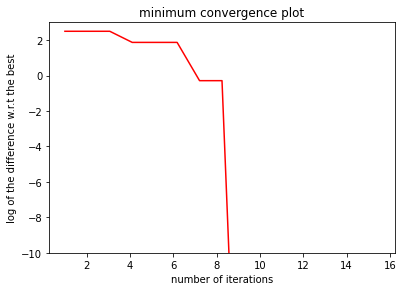

In [ ]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 3]
    #  enum 1
    c1 = X[:, 0]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 1]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 2]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y
#to run the optimization process
n_iter = 15
xtypes = [(ENUM, 3), (ENUM, 2), ORD,FLOAT]
xlimits = np.array([["blue", "red", "green"], ["large", "small"], ["0","1","2"],[-5, 5]])
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"
sm = KRG(print_global=False)

n_doe = 2
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    xtypes=xtypes,
    xlimits=xlimits,
    surrogate=sm,
    qEI=qEI,
    categorical_kernel= GOWER,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()



In [ ]:
print(" 4D EGO Optimization: Minimum in x=",cast_to_mixed_integer(xtypes, xlimits, x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= ['green', 'large', 0, -4.999999999999995] with y value = [-15.]


# Group kernel mixed based optimization 4D function 

There is two distinct models : the homoscedastic one (HOMO_GAUSSIAN) that does not considerer different variances between the variables and the heteroscedastic one (HETERO_GAUSSIAN)

For mixed integer with Group kernels, the reference thesis is available here https://hal.inria.fr/tel-03113542/document

Initial DOE: 
 xdoe =  [[ 1.          0.          2.          3.93889915]
 [ 2.          1.          1.         -1.9036956 ]] 
 ydoe =  [ 9.87779829 -4.42553246]


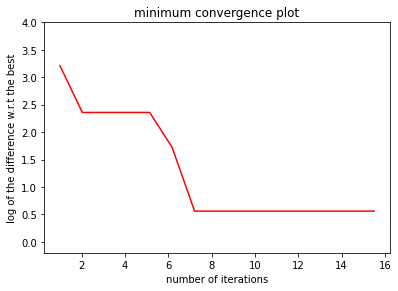

In [ ]:
#to define the 4D function 
def function_test_mixed_integer(X):
    import numpy as np

    # float
    x1 = X[:, 3]
    #  enum 1
    c1 = X[:, 0]
    x2 = c1 == 0
    x3 = c1 == 1
    x4 = c1 == 2
    #  enum 2
    c2 = X[:, 1]
    x5 = c2 == 0
    x6 = c2 == 1
    # int
    i = X[:, 2]

    y = (
        (x2 + 2 * x3 + 3 * x4) * x5 * x1
        + (x2 + 2 * x3 + 3 * x4) * x6 * 0.95 * x1
        + i
    )
    return y
#to run the optimization process
n_iter = 15
xtypes = [(ENUM, 3), (ENUM, 2), ORD,FLOAT]
xlimits = np.array([["blue", "red", "green"], ["large", "small"], ["0","1","2"],[-5, 5]])
criterion = "EI"  #'EI' or 'SBO' or 'LCB'
qEI = "KB"
sm = KRG(print_global=False)

n_doe = 2
sampling = MixedIntegerSamplingMethod(xtypes, xlimits, LHS, criterion="ese")
xdoe = sampling(n_doe)
ydoe = function_test_mixed_integer(xdoe)
print('Initial DOE: \n', 'xdoe = ',xdoe, '\n ydoe = ',ydoe)

ego = EGO(
    n_iter=n_iter,
    criterion=criterion,
    xdoe=xdoe,
    ydoe=ydoe,
    xtypes=xtypes,
    xlimits=xlimits,
    surrogate=sm,
    qEI=qEI,
    categorical_kernel= HOMO_GAUSSIAN,
)

x_opt,y_opt, _, _, y_data = ego.optimize(fun=function_test_mixed_integer)

#to plot the objective function during the optimization process
min_ref = -15
mini = np.zeros(n_iter)
for k in range(n_iter):
    mini[k] = np.log(np.abs(np.min(y_data[0 : k + n_doe - 1]) - min_ref))
x_plot = np.linspace(1, n_iter + 0.5, n_iter)
u = max(np.floor(max(mini)) + 1, -100)
l = max(np.floor(min(mini)) - 0.2, -10)
fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(x_plot, mini, color="r")
axes.set_ylim([l, u])
plt.title("minimum convergence plot", loc="center")
plt.xlabel("number of iterations")
plt.ylabel("log of the difference w.r.t the best")
plt.show()



In [ ]:
print(" 4D EGO Optimization: Minimum in x=",cast_to_mixed_integer(xtypes, xlimits, x_opt), "with y value =",y_opt)

 4D EGO Optimization: Minimum in x= ['green', 'small', 1, -5.0] with y value = [-13.25]
